In [1]:
import time
import matplotlib.pyplot as plt
from keras.layers import *
from keras.engine.training import Model
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.models import load_model
import keras.backend as K

import random
import numpy as np
import pickle
import json
import os
from pathlib import Path

current_file_path = Path(get_ipython().run_line_magic('pwd', ''))
root_path = current_file_path
while not any(file.suffix == ".ipynb" for file in root_path.glob("*")):
    root_path = root_path.parent

root_path = str(root_path)
print(root_path)


board_width = 15
board_height = 15
last_n_feature=1
input_shape=(4+last_n_feature,  board_width,  board_height)
l2_const = 1e-4
batch_size=512
epochs=50
init_lr=1e-4
is_load_model=False
take_last_n_move=5
load_model_dir=None# xx_xx_xxxxxx
sample_size=5 #games


c:\Users\88692\Desktop\model_pre_train\model_training


In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6762016054222379470
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 2236245607
locality {
  bus_id: 1
  links {
  }
}
incarnation: 14675438409487866762
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5"
xla_global_id: 416903419
]


In [3]:
data_dir = os.path.join(root_path,f'training_data_v{last_n_feature}')
data_files = os.listdir(data_dir)
data = []
for file in data_files:
    print(f"loading file {file}...")
    file = os.path.join(data_dir,file)
    with open(file, 'rb') as f:
        data += pickle.load(f)
    print(f"file {file} loaded")
print(len(data))



loading file data_from_json...
file c:\Users\88692\Desktop\model_pre_train\model_training\training_data_v1\data_from_json loaded
loading file data_from_pickle...
file c:\Users\88692\Desktop\model_pre_train\model_training\training_data_v1\data_from_pickle loaded
1528


In [4]:

status = []
probs = []
wins = []
result = []
moves = []
print(len(data))
data=random.sample(data,sample_size)
print(len(data))
for idx,i in enumerate(data):
    print(idx,len(i))

for game in data:
    for move_n in game:
        moves.append(move_n)
random.shuffle(moves)
# print(moves[0])
for i in moves:
    status.append(i[0])
    probs.append(i[1])
    wins.append(i[2])

train_size = int(0.8*len(status))
print("total status:{}".format(len(status)))

x_train = status[:train_size]
x_test = status[train_size:]

y_train_probs = probs[:train_size]
y_test_probs = probs[train_size:]

y_train_wins = wins[:train_size]
y_test_wins = wins[train_size:]

print(len(x_train))
print(len(x_test))

x_train = np.asarray(x_train)
x_test = np.asarray(x_test)

y_train_probs = np.asarray(y_train_probs)
y_train_probs = np.reshape(y_train_probs, (y_train_probs.shape[0], -1))
y_train_wins = np.asarray(y_train_wins)

y_test_probs = np.asarray(y_test_probs)
y_test_probs = np.reshape(y_test_probs, (y_test_probs.shape[0], -1))
y_test_wins = np.asarray(y_test_wins)


1528
5
0 5
1 5
2 5
3 5
4 5
total status:25
20
5


In [5]:
def model_structure(input_shape,l2_const):
    
    def resnext_block(inputs, filters, cardinality=32, strides=1):
        x = Conv2D(filters, kernel_size=3,kernel_regularizer=l2(l2_const),
                strides=strides,padding='same')(inputs)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = Conv2D(filters, kernel_size=3,kernel_regularizer=l2(l2_const),
                strides=strides,padding='same')(inputs)
        x = BatchNormalization()(x)
        x = add([inputs, x])
        x = Activation('relu')(x)
        return x
    in_x = network = Input(input_shape)
    network = Conv2D(filters=64, kernel_size=3,kernel_regularizer=l2(l2_const),
                          strides=1, padding='same')(network)
    network = BatchNormalization()(network)
    network = Activation('relu')(network)
    network = resnext_block(network, 64)
    network = resnext_block(network, 64)
    network = resnext_block(network, 64)
    network = resnext_block(network, 64)
    network = resnext_block(network, 64)
    network = resnext_block(network, 64)
    network = resnext_block(network, 64)
    # action policy layers
    policy_net = Conv2D(filters=2, kernel_size=(1, 1), data_format="channels_first",
                        kernel_regularizer=l2(l2_const), name="policy_net_input")(network)
    policy_net = BatchNormalization()(policy_net)
    policy_net = Activation("relu")(policy_net)
    policy_net = Flatten()(policy_net)
    policy_net = Dense(board_width * board_height,
                    activation="softmax", kernel_regularizer=l2(l2_const), name="policy_net")(policy_net)
    # state value layers
    value_net = Conv2D(filters=1, kernel_size=(1, 1), data_format="channels_first",
                    kernel_regularizer=l2(l2_const), name="value_net_input")(network)
    value_net = BatchNormalization()(value_net)
    value_net = Activation("relu")(value_net)
    value_net = Flatten()(value_net)
    value_net = Dense(256, kernel_regularizer=l2(l2_const))(value_net)
    value_net = Activation("relu",)(value_net)
    value_net = Dense(1, activation="tanh",
                    kernel_regularizer=l2(l2_const), name="value_net")(value_net)

    model = Model(in_x, [policy_net,  value_net])
    return model

In [6]:


if(is_load_model):
    model=load_model(os.path.join(root_path,'model_record',load_model_dir,'model.h5'))
else:
    model=model_structure(input_shape,l2_const)

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=init_lr,
    decay_steps=10000,
    decay_rate=0.9)

optimizer = Adam(
    learning_rate=lr_schedule, beta_1=0.9, beta_2=0.999)

model.compile(
    optimizer=optimizer,
    loss=['categorical_crossentropy', 'mean_squared_error'],
    metrics=['accuracy']
)

print(model.summary())


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 5, 15, 15)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 5, 15, 64)    8704        ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 5, 15, 64)   256         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 5, 15, 64)    0           ['batch_normalization[0][0]']

In [7]:
try:
    start_time=time.process_time()
    history = model.fit(x_train,
                    [y_train_probs, y_train_wins],
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_split=0.2,
                    verbose=1,
                    validation_data=(x_test, [y_test_probs, y_test_wins]))
    precess_time=time.process_time()-start_time
except KeyboardInterrupt as e:
    print(e)


Epoch 1/50
1/1 [==============================] - 12s 12s/step - loss: 7.2452 - policy_net_loss: 5.8626 - value_net_loss: 1.2540 - policy_net_accuracy: 0.0500 - value_net_accuracy: 0.1000 - val_loss: 7.5724 - val_policy_net_loss: 6.9817 - val_value_net_loss: 0.4621 - val_policy_net_accuracy: 0.0000e+00 - val_value_net_accuracy: 0.0000e+00
Epoch 2/50
1/1 [==============================] - 0s 67ms/step - loss: 5.8761 - policy_net_loss: 5.5662 - value_net_loss: 0.1814 - policy_net_accuracy: 0.0500 - value_net_accuracy: 0.5000 - val_loss: 7.3158 - val_policy_net_loss: 6.7448 - val_value_net_loss: 0.4424 - val_policy_net_accuracy: 0.0000e+00 - val_value_net_accuracy: 0.0000e+00
Epoch 3/50
1/1 [==============================] - 0s 65ms/step - loss: 5.3874 - policy_net_loss: 5.2293 - value_net_loss: 0.0296 - policy_net_accuracy: 0.0500 - value_net_accuracy: 0.7000 - val_loss: 7.1033 - val_policy_net_loss: 6.5471 - val_value_net_loss: 0.4277 - val_policy_net_accuracy: 0.0000e+00 - val_value_ne

1/1 [==============================] - 0s 59ms/step - loss: 5.9707 - policy_net_loss: 5.4437 - value_net_loss: 0.4016 - policy_net_accuracy: 0.0000e+00 - value_net_accuracy: 0.0000e+00


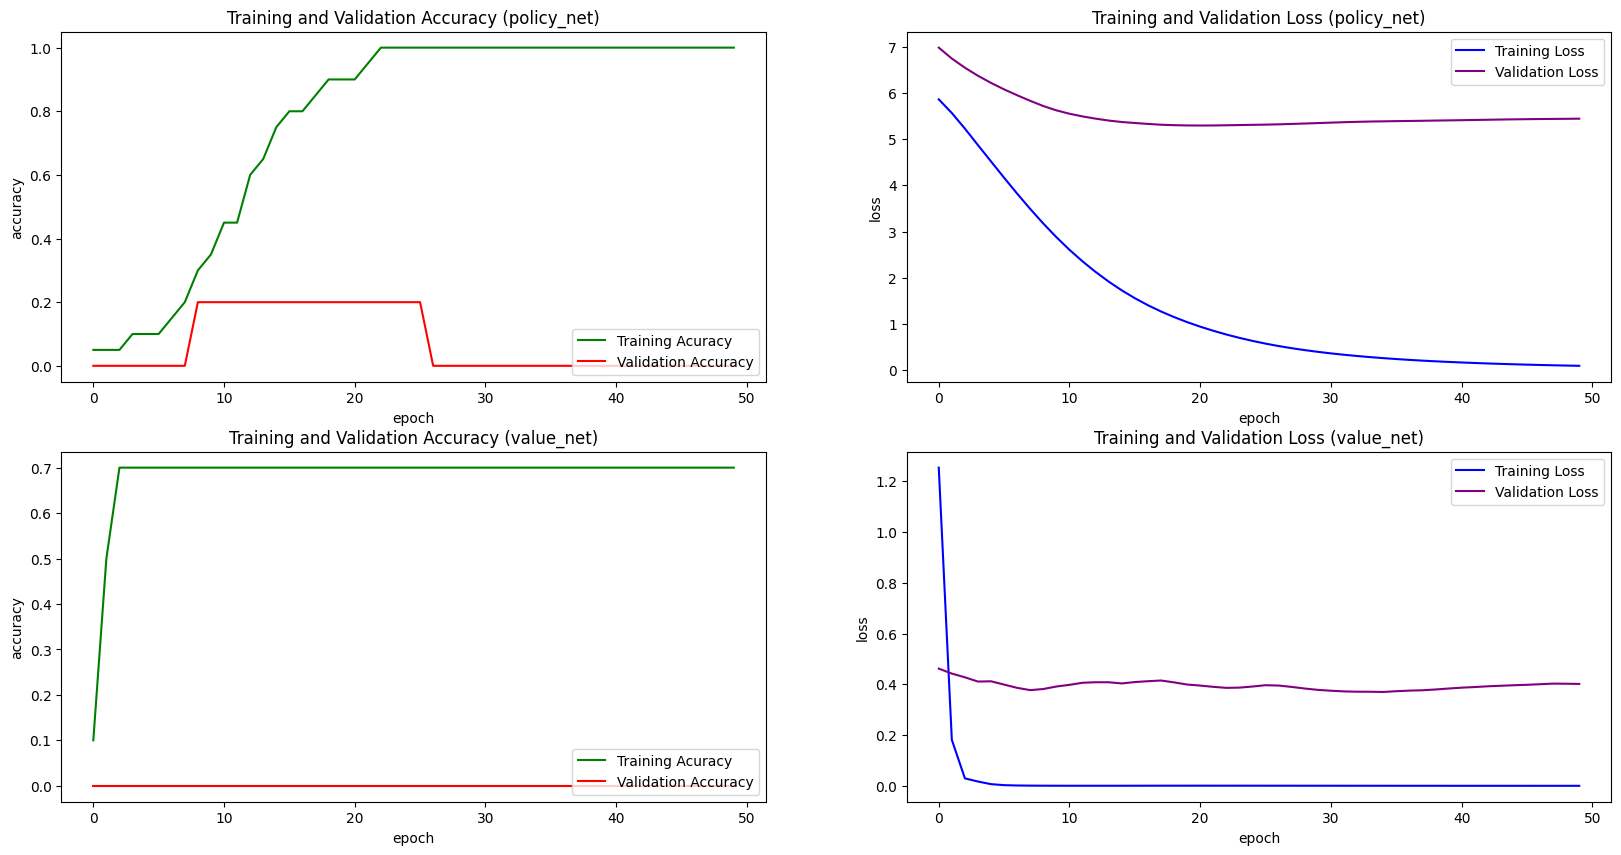

policy val acc = 0.0
policy val loss = 5.4436750411987305
value val acc = 0.0
value val loss = 0.4016406536102295


In [8]:
result=history

policy_net_loss = result.history['policy_net_loss']
policy_net_accuracy = result.history['policy_net_accuracy']
val_policy_net_loss = result.history['val_policy_net_loss']
val_policy_net_accuracy = result.history['val_policy_net_accuracy']

value_net_loss = result.history['value_net_loss']
value_net_accuracy = result.history['value_net_accuracy']
val_value_net_loss = result.history['val_value_net_loss']
val_value_net_accuracy = result.history['val_value_net_accuracy']

plt.figure(figsize=(20, 10))
plt.subplot(2, 2, 1)
plt.title("Training and Validation Accuracy (policy_net)")
plt.plot(policy_net_accuracy, color='green', label='Training Acuracy')
plt.plot(val_policy_net_accuracy, color='red', label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.subplot(2, 2, 2)
plt.title('Training and Validation Loss (policy_net)')
plt.plot(policy_net_loss, color='blue', label='Training Loss')
plt.plot(val_policy_net_loss, color='purple', label='Validation Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper right')

plt.subplot(2, 2, 3)
plt.title("Training and Validation Accuracy (value_net)")
plt.plot(value_net_accuracy, color='green', label='Training Acuracy')
plt.plot(val_value_net_accuracy, color='red', label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.subplot(2, 2, 4)
plt.title('Training and Validation Loss (value_net)')
plt.plot(value_net_loss, color='blue', label='Training Loss')
plt.plot(val_value_net_loss, color='purple', label='Validation Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper right')

score = model.evaluate(
    x_test, [y_test_probs, y_test_wins], verbose=1)

# print("Testing Accuracy = %.2f %%    loss = %f" % (accuracy * 100, loss))
fig=plt.gcf()
plt.show()
print(f"policy val acc = {score[3]}")
print(f"policy val loss = {score[1]}")
print(f"value val acc = {score[4]}")
print(f"value val loss = {score[2]}")

In [9]:

t = time.localtime()
folder_name = f"{t.tm_mon:0>2}_{t.tm_mday:0>2}_{t.tm_hour:0>2}{t.tm_min:0>2}{t.tm_sec:0>2}"
new_folder_dir=os.path.join(root_path,'model_record',folder_name)
os.makedirs(new_folder_dir, exist_ok=True)

In [10]:

def convert_seconds(seconds):
    seconds=int(seconds)
    hours = seconds // 3600
    minutes = (seconds % 3600) // 60
    seconds = seconds % 60
    return f"{hours:0>3}h {minutes:0>2}m {seconds:0>2}s"

fig.savefig(os.path.join(new_folder_dir,'history.png'))
model.save(os.path.join(new_folder_dir,'model.h5'))

with open(os.path.join(new_folder_dir,'result.txt'), 'w') as f:
    f.write(f"load model = {is_load_model}\n")
    f.write(f"load model dir = {load_model_dir}\n")
    f.write(f"epochs = {epochs}\n")
    f.write(f"batch_size = {batch_size}\n")
    f.write(f"sample_size = {sample_size}\n")
    f.write(f"take_last_n_move = {take_last_n_move}\n")
    f.write(f"input_shape = {input_shape}\n")
    f.write(f"last_n_feature = {last_n_feature}\n")
    f.write(f"init lr = {init_lr}\n")
    f.write(f"l2 const = {l2_const}\n")
    f.write(f"policy val acc = {score[3]}\n")
    f.write(f"policy val loss = {score[1]}\n")
    f.write(f"value val acc = {score[4]}\n")
    f.write(f"value val loss = {score[2]}\n")
    f.write(f"precess time = {convert_seconds(precess_time)}\n")

python_file_name="manual_data_training.ipynb"
with open(python_file_name) as f:
    code = f.read()
    f.close()
json_code = json.loads(code)
model_structure=json_code['cells'][4]
with open(os.path.join(new_folder_dir,"model_structure.txt"), mode="w") as f:
    f.write("".join(model_structure['source']))
    f.close()